Output()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Training complete

Some logging happening completed

Reset training state

Asserting converged

Output()

Training complete

Some logging happening completed

Reset training state

Asserting converged

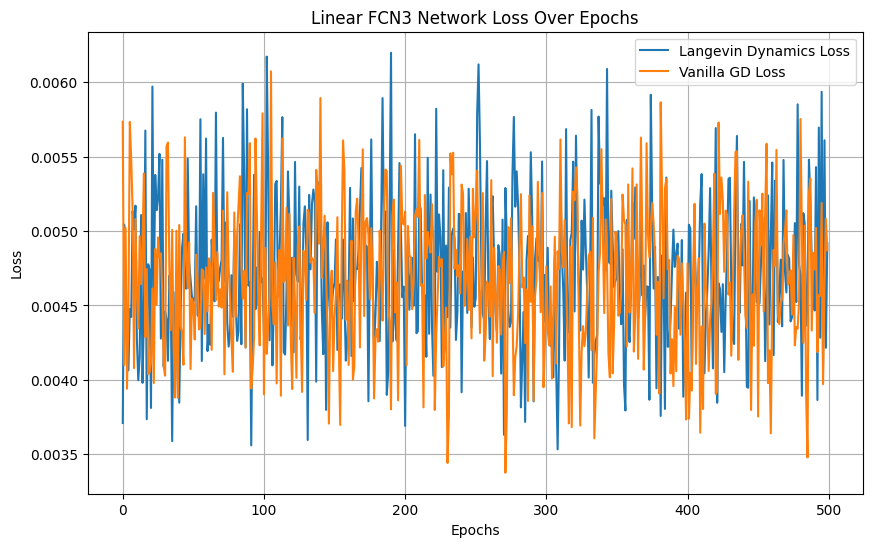

In [14]:
%load_ext autoreload
%autoreload 2
from FCN3 import *
# In your IPython Notebook (Revised)
import torch


from torch import nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple
import standard_hyperparams as hp
from logger import *
def activation(x):
    return x
# --- Hyperparameters ---
input_dimension: int = 10
T = 1.0
kappa = T

hidden_width1: int = 32
hidden_width2: int = 16

λ1 = T * input_dimension #weight decay factor
λ2 = T * hidden_width1
λ3 = T * hidden_width2

weight_sigma1: float = 1.0/input_dimension
weight_sigma2: float = 1.0/hidden_width1
weight_sigma3: float = 1.0/(hidden_width2)
num_data_points: int = 500
batch_size: int = 100
learning_rate: float = 0.0000015
noise_std_ld: float = (2 * learning_rate * T )**0.5
num_epochs: int = 500

weight_decay_config: dict = {
            'fc1.weight': λ1,
            'fc2.weight': λ2,
            'fc3.weight': λ3,
            'fc1.bias': 0.0,
            'fc2.bias': 0.0,
            'fc3.bias': 0.0,
}

teacher : SimpleNet = SimpleNet(
    input_dimension,
    linear_activation,
    1/input_dimension
).to(hp.DEVICE)
# Generate a Dataset out of a teacher network
raw_X = HypersphereData.sample_hypersphere(num_data_points, input_dimension, normalized=True).to(hp.DEVICE)
raw_Y = (teacher(raw_X).detach())
hypersphere_dataset: DataManager = DataManager(raw_X, raw_Y, split = 0.8)

train_data_subset: TensorDataset = hypersphere_dataset.train_dataset
train_X : torch.Tensor = hypersphere_dataset.tensors[0][train_data_subset.indices]
train_Y : torch.Tensor = hypersphere_dataset.tensors[1][train_data_subset.indices]
test_data_subset: TensorDataset = hypersphere_dataset.test_dataset
test_X : torch.Tensor = hypersphere_dataset.tensors[0][test_data_subset.indices]
test_Y : torch.Tensor = hypersphere_dataset.tensors[1][test_data_subset.indices]

weight_sigma = (weight_sigma1,
    weight_sigma2,
    weight_sigma3)

# --- Initialize Network ---
# Example: Linear activation network
hyperparameters : Dict = {
    'input_dimension': input_dimension,
    'hidden_width_1': hidden_width1,
    'hidden_width_2': hidden_width2,
    'activation': activation,
    'output_activation': activation,
    'weight_sigma1': weight_sigma1,
    'weight_sigma2': weight_sigma2,
    'weight_sigma3': weight_sigma3,
}
langevin_model: FCN3Network = FCN3Network.model_from_hyperparameters(hyperparameters).to(hp.DEVICE)

standard_model: FCN3Network = FCN3Network.model_from_hyperparameters(hyperparameters).to(hp.DEVICE)

trainer : NetworkTrainer = NetworkTrainer(
    model=standard_model,
    manager=hypersphere_dataset,
    batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay_config=weight_decay_config,
    num_epochs=num_epochs
)


langevin_trainer : LangevinTrainer = LangevinTrainer(
    model=langevin_model,
    manager=hypersphere_dataset,
    batch_size=batch_size,
    learning_rate=learning_rate,
    noise_std=noise_std_ld,
    weight_decay_config=weight_decay_config,
    num_epochs=num_epochs
)
def epoch_save_generic(model,trainer):
  if trainer.current_epoch % 50 == 0:

    # Save the Langevin model
    filename = f"./fcn3_generic.pth"
    # torch.save(trainer.model.state_dict(), filename)
    print(f"Langevin model saved to: {filename}")

def lang_save(trainer):
  #epoch_save_generic(trainer, "langevin_model")
  return

def std_save(trainer):
  # epoch_save_generic(trainer, "standard_model")
  return

# print("Beginning Langevin training")
loggerlang = Logger(num_epochs=num_epochs,
                description=f"Training YURI 1")

with loggerlang:
    langevin_trainer.train(logger=loggerlang);


loggerreg = Logger(num_epochs=num_epochs,
                description=f"Training YURI 1")

with loggerreg:
    trainer.train(logger=loggerreg);    
    
import matplotlib.pyplot as plt
gd_loss = trainer.training_info.trainloss
langevin_loss = langevin_trainer.training_info.trainloss
# Plot train and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(len(langevin_loss)), langevin_loss, label='Langevin Dynamics Loss')
plt.plot(range(len(gd_loss)), gd_loss, label='Vanilla GD Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Linear FCN3 Network Loss Over Epochs')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.show()

In [ ]:
langevin_trai

In [ ]:
import matplotlib.pyplot as plt
# gd_loss = trainer.training_info.trainloss
langevin_loss = langevin_trainer.training_info.trainloss
# Plot train and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(len(langevin_loss)), langevin_loss, label='Langevin Dynamics Loss')
plt.plot(range(len(gd_loss)), gd_loss, label='Vanilla GD Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Linear FCN3 Network Loss Over Epochs')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.show()